Notebook for STM double tip simulation

In [30]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
import os
import random
from scipy.ndimage import gaussian_filter, median_filter
from matplotlib import pyplot as plt

from pathlib import Path

In [12]:
def create_double_gaussian_kernel(size, peak1, peak2, sigma1, sigma2):
    kernel = np.zeros((size, size))
    
    # Create the first Gaussian peak
    kernel[peak1] = 1
    kernel = gaussian_filter(kernel, sigma=sigma1)
    
    # Create the second Gaussian peak
    kernel2 = np.zeros((size, size))
    kernel2[peak2] = 1
    kernel2 = gaussian_filter(kernel2, sigma=sigma2)
    
    # Combine the two Gaussians
    combined_kernel = kernel + kernel2
    
    return combined_kernel

# Define the kernel size and Gaussian parameters
kernel_size = 16
peak1 = (4, 4)  # Position of the first peak
peak2 = (11, 11)  # Position of the second peak
sigma1 = 1.0  # Standard deviation of the first Gaussian
sigma2 = 1.0  # Standard deviation of the second Gaussian

# Create the double Gaussian kernel
kernel = create_double_gaussian_kernel(kernel_size, peak1, peak2, sigma1, sigma2)

# Normalize the kernel
kernel /= np.sum(kernel)

print("Kernel shape:", kernel.shape)
print(kernel)

from scipy.ndimage import convolve

# Example array of shape (512, 512)
array = np.random.rand(512, 512)

# Convolve the array with the kernel
convolved_array = convolve(array, kernel)

print("Convolved array shape:", convolved_array.shape)


Kernel shape: (16, 16)
[[8.95531804e-09 2.96559404e-07 3.61283315e-06 1.61915949e-05
  2.66954268e-05 1.61915949e-05 3.61283315e-06 2.96559404e-07
  8.95531804e-09 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.96559404e-07 9.82069871e-06 1.19640603e-04 5.36191982e-04
  8.84031125e-04 5.36191982e-04 1.19640603e-04 9.82069871e-06
  2.96559404e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.61283315e-06 1.19640603e-04 1.45752092e-03 6.53215558e-03
  1.07697038e-02 6.53215558e-03 1.45752092e-03 1.19640603e-04
  3.61283315e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.61915949e-05 5.36191982e-04 6.53215558e-03 2.92750903e-02
  4.82664640e-02 2.92750903e-02 6.53215558e-03 5.36191982e-04
  1.61915949e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+

In [850]:
# custom transforms 

class Double_tip1(object):
  '''
  Add a double tip artefact to the image. The parameters of the double tip are chosen randomly so
  each image will have a different double tip artefact.
  '''

  def __init__(self):
    pass

  def sigmoid(self, x, a,b):
    '''
    A sigmoid function that takes in an array x and parameters a and b.
    This is used to rescale the pixel values in the "doubled" image (the brighter ones 
    are often the ones that are doubled more clearly).
    args:
    x: array of pixel values
    a: parameter of the sigmoid function
    b: parameter of the sigmoid function
    returns:
    array of pixel values rescaled by the sigmoid function
    '''
    return 1 / (1 + np.exp(a-b*x))

  def __call__(self,array):
      # get random values for a and b
      # can adjust limits, these are preliminary
      b = np.random.uniform(8, 10)
      num_stds = np.random.uniform(3, 6.5)
      a = (torch.mean(array).item() + num_stds*torch.std(array).item()) * b
      print(a,b,num_stds)
      # Apply the sigmoid function to each pixel value
      sigmoid_array = self.sigmoid(array,a,b)
      # Offset each pixel by a random value in x and y (between 5 and 10)
      # Generate random offsets for x and y
      offset_x = torch.randint(-10, 11, (1,))[0]
      offset_y = torch.randint(-10, 11, (1,))[0]
      print('offset in x and y: ', offset_x, offset_y)
      
      # Ensure offsets are within bounds
      _, rows, cols = array.shape
      
      # random integer between 0 and 11
      #median_size = np.random.randint(1, 11)
      gaussian_std = np.random.uniform(1, 10)
     # print('median filter size: ', median_size)

      # Apply median filter to the sigmoid image
      #filtered_offset = median_filter(sigmoid_array, size=(1,median_size,median_size))  # You can adjust the size of the filter
      filtered_offset = gaussian_filter(sigmoid_array, sigma=gaussian_std)

      # Create a copy of the base array
      result = torch.clone(array)

      # Add the add_array to the base_array with the offset
      # then crop it so it only includes the parts where the two arrays are overlaid
      if offset_x >= 0 and offset_y >= 0:
        # Positive offsets
        result[:,offset_x:, offset_y:] += filtered_offset[:,:rows-offset_x, :cols-offset_y]
        result = result[:,offset_x:, offset_y:]
        label = array[:,offset_x:, offset_y:]
      elif offset_x >= 0 and offset_y < 0:
        # Negative y-offset
        result[:,offset_x:, :offset_y] += filtered_offset[:,:rows-offset_x, -offset_y:]
        result = result[:,offset_x:, :offset_y]
        label = array[:,offset_x:, :offset_y]
      elif offset_x < 0 and offset_y >= 0:
        # Negative x-offset
        result[:,:offset_x, offset_y:] += filtered_offset[:,-offset_x:, :cols-offset_y]
        result = result[:,:offset_x, offset_y:]
        label = array[:,:offset_x, offset_y:]
      else:  # offset_x < 0 and offset_y < 0
        # Negative offsets for both x and y
        result[:,:offset_x, :offset_y] += filtered_offset[:,-offset_x:, -offset_y:]
        result = result[:,:offset_x, :offset_y]
        label = array[:,:offset_x, :offset_y]

      return torch.stack( (result, label), dim=0)


class RandomScanLineArtefact(object):
    '''
    Randomly adds scan line artefacts to the image.
    Does a few different types of scan line artefacts:
    - Adds a constant to a single line in the image but for a longer length
    - Adds a constant to two lines in the image but for a longer length 
    - Adds a sinusoidal wave to a single line in the image
    - Adds a sinusoidal wave to two lines in the image
    - Adds a constant to a single line in the image but for a shorter length
    '''
    def __init__(self, p):
        self.p = p

    def __call__(self, scan):
        r1 = random.random()
        r2 = random.random()
        scan_maxmin = (torch.clone(scan)-torch.min(scan))/(torch.max(scan)-torch.min(scan))

        if r1 < self.p:
          rng = np.random.default_rng(12345) # random number generator
          res = scan.shape[1]
          num_lines = 15 # number of lines to add artefact to
          lines = rng.integers(0,res, (num_lines,)) # which scan lines to augment
          columns = rng.integers(0,res, (num_lines,)) # the columns where the artefacts begin
          lengths = rng.integers(0, int(res*0.8), (num_lines,)) # the length of the artefacts
          add_ons = rng.random(size=(num_lines,))/1.67 # random number between 0 and ~0.6 to add on to a scan line
          # add constant to single line
          for i in range(7):
            scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] = scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] + add_ons[i]
          # add constant to two lines one
          for i in range(7,9):
            scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]] = scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]] + add_ons[i]
          # add sinusoidal to single line
          for i in range(9,13):
            end = rng.integers(200,314)/100
            lengths[i] = scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]].shape[0] # correct length in case its too long
            cos = np.cos(np.linspace(0, end, num=lengths[i]) )
            scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] = scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] + cos*add_ons[i]
          # add sinusoidal to two lines
          for i in range(13,15):
            end = rng.integers(200,314)/100
            lengths[i] = scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]].shape[1] # correct length in case its too long
            cos = np.cos(np.linspace(0, end, num=lengths[i]) )
            scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]] = scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]] + cos*add_ons[i]

        if r2 < self.p:
          # add some shorter scan line artefacts
          rng = np.random.default_rng(12345) # random number generator
          res = scan.shape[1]
          lines = rng.integers(0,res, (10,)) # which scan lines to augment
          columns = rng.integers(0,res, (10,)) # the columns where the artefacts begin
          lengths = rng.integers(0, int(res*0.1) , (10,)) # the length of the artefacts
          add_ons = rng.random(size=(10,))/1.67 # random number between 0 and ~0.6 to add on to a scan line
          for i in range(10):
            scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] =scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] + add_ons[i]

        return scan_maxmin

# Custom transformation for random rotation
class RandomRotation_(object):
    '''
    Randomly rotates the image by an angle chosen from a list of angles.
    '''
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, img):
        img.transpose(0,1)
        angle = random.choice(self.angles)
        img_ =  F.rotate(img, angle)
        img_.transpose(0,1)
        return img_


class RandomCreep(object):
    '''
    Adds a creep to the top of the image with a probability of p.
    '''
    def __init__(self, p):
        self.p = p

    def __call__(self, scan):
        r = random.random()
        r2 = random.random()
        if r < self.p:
          # generate 3 random ints
          num_lines = np.random.randint(40,50) # num lines the creep is visible in
          a1 = np.random.randint(0,50)
          a2 = np.random.randint(0,50) # factors in the creep polynomial
          scan_ = torch.clone(scan)
          #print('num_lines: ', num_lines, 'a1: ', a1, 'a2: ', a2, 'r2: ', r2)
          if r2 < 0.5:
            # add creep to top
            if scan.dim() == 3:
              for i in range(0,num_lines):
                j = num_lines-i
                roll = (a1*i*i//250 + a2*i*i//100 +i*i//50) // 10
                scan_[0,2*j:2*(j+1),:] = torch.roll(scan[0,2*j:2*(j+1),:], -roll, dims=1)    
            elif scan.dim() == 2:
              for i in range(0,num_lines):
                j = num_lines-i
                roll = a1*i*i//250 + a2*i*i//100 +i*i//50
                scan_[2*j:2*(j+1),:] = torch.roll(scan[2*j:2*(j+1),:], -roll, dims=0)
          else:
            res = scan.shape[1]   
            if scan.dim() == 3:
              for i in range(res-num_lines,res):
                j = num_lines-i
                roll = (a1*i*i//250 + a2*i*i//100 +i*i//50) // 10
                scan_[0,2*j:2*(j+1),:] = torch.roll(scan[0,2*j:2*(j+1),:], -roll, dims=1)    
            elif scan.dim() == 2:
              for i in range(res-num_lines,res):
                j = num_lines-i
                roll = a1*i*i//250 + a2*i*i//100 +i*i//50
                scan_[2*j:2*(j+1),:] = torch.roll(scan[2*j:2*(j+1),:], -roll, dims=0)
          return scan_
        
        else:
          return scan
    
    
class MedianFilter(object):
    '''
    Applies a median filter to the image.
    '''
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        # Convert the image to a NumPy array
        img_np = np.array(img)
        
        # Apply the median filter
        filtered_img_np = median_filter(img_np, size=self.size)
        
        # Convert the filtered image back to a tensor
        filtered_img = torch.tensor(filtered_img_np)
        
        return filtered_img
    

class Get_FFT(object):
    '''
    Applies a 2D FFT to the image.
    '''
    def __init__(self):
        pass

    def __call__(self, img):
        # make a 2d hanning window to avoid edge effects
        hanning = torch.hann_window(img.shape[1])
        hanning = hanning.unsqueeze(0) * hanning.unsqueeze(1)
        
        # Apply the 2D FFT
        fft_img = torch.fft.fft2(hanning*img[0,:,:])
        # shift the zero to centre
        fft_img = torch.fft.fftshift(fft_img)
        
        # Compute the magnitude of the FFT
        fft_img_real = torch.real(fft_img)#.squeeze(0)
        fft_img_imag = torch.imag(fft_img)#.squeeze(0)
        # max/min normalise both of them
        fft_img_real = (fft_img_real - torch.min(fft_img_real))/(torch.max(fft_img_real) - torch.min(fft_img_real))
        fft_img_imag = (fft_img_imag - torch.min(fft_img_imag))/(torch.max(fft_img_imag) - torch.min(fft_img_imag))
        print('fft_img_real shape: ', fft_img_real.shape)
        print('fft_img_imag shape: ', fft_img_imag.shape)
        
        return torch.stack((fft_img_real, fft_img_imag), dim=0)

In [ ]:
class STM_double_tip_dataset(Dataset):
    def __init__(self, image_dir, empty = False):
        '''
        Args:
            image_dir (string): Directory with all the images. These are assumed as being numpy arrays. 
                                Either with shape (res,res,2) (filled and empty), or just (res,res) (filled only).
            empty (bool): If True, the images are assumed as having filled and empty state images and both are wanted.
                          If False, we take only the filled state images.
        '''
        self.empty = empty
        self.image_dir = image_dir
        # check all files in image_dir have the same shape
        shapes = [len(np.load(image_dir/f).shape) for f in os.listdir(image_dir)]
        if all(s==3 for s in shapes):
            pass
        elif all(s==2 for s in shapes):
            pass
        else:
            raise ValueError('All files in image_dir must have the same shape. Either (res,res,2) or (res,res).')
        # load the data
        shape = shapes[0]
        if empty and shape == 3:
            self.image_files = [torch.tensor(np.load(image_dir/f)) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        elif empty and shape == 2:
            raise ValueError('empty=True only makes sense if the images have two channels.')
        elif not empty and shape == 2:
            self.image_files = [torch.tensor(np.load(image_dir/f)) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        elif not empty and shape == 3:
            self.image_files = [torch.tensor(np.load(image_dir/f))[0,:,:] for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        
        self.transforms_both = transforms.Compose([
            Double_tip1(),
            RandomRotation_([0, 90, 180, 270])
            ])
        
        self.creep_transform = RandomCreep(1)
        
        self.transforms_noise = transforms.Compose([
            MedianFilter(3),
            RandomScanLineArtefact(0.5),
        ])

        '''
        Transforms order: random blur, random rotation, random brightness, creep, double tip, crop, resize
        '''

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        idx = idx % self.__len__()
        image = self.image_files[idx].unsqueeze(0)
        # max/min normalization
        image = (image-torch.min(image))/(torch.max(image)-torch.min(image))
        #print(image.shape)
        # transforms_both returns the original image (in first channel), and the double tip image in zeroth channel
        image = self.transforms_both(image)
        # We crop it after making the double tip, since the Double_tip1 transform
        # returns a non-square array (due to overlaying two images with a random offset in x and y)
        image = transforms.RandomCrop(500)(image)
        
        # The "label" is the original image, the "image" is the image with the double tip
        label = image[1,:,:]
        image = image[0,:,:]

        # Apply noise transforms, these are applied to the image only, not the "label"
        image = self.transforms_noise(image)
        
        # get fft
        fft = Get_FFT()(image)
        print('fft shape: ', fft.shape)
        # stack it with the image to get a 3 channel image
        image = torch.vstack((image, fft))
        return image, label

In [864]:
# get directory
cwd = Path.cwd()
data_dir =  cwd / 'filled_empty'

# create instance of dataset
test_dataset = STM_double_tip_dataset(data_dir, empty=False)

7.596588609710154 9.797366304287419 3.6157527666421005
offset in x and y:  tensor(-9) tensor(-4)
fft_img_real shape:  torch.Size([100, 100])
fft_img_imag shape:  torch.Size([100, 100])
fft shape:  torch.Size([2, 100, 100])


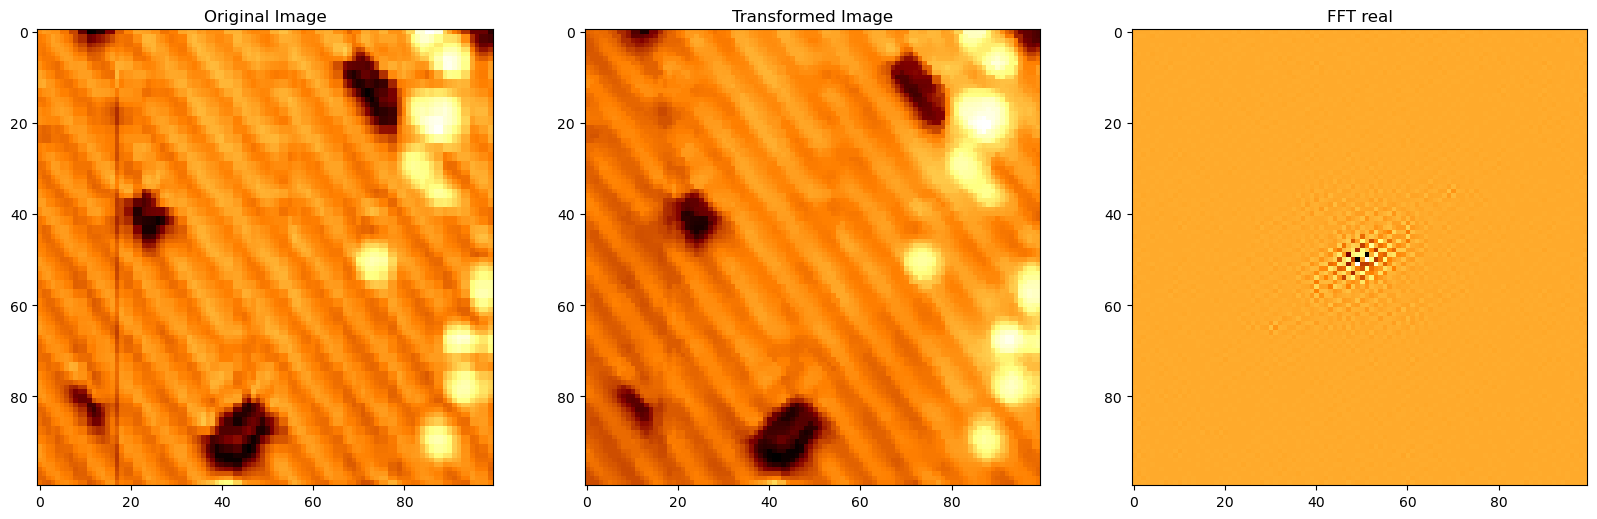

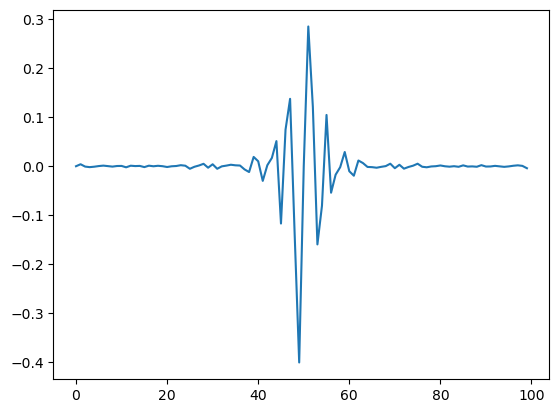

In [870]:
# plot some outputs

for i in range(1):
    test_im = test_dataset[i]
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    
    # Plot the original image
    ax[0].imshow(test_im[1][0,:,:], cmap='afmhot')
    ax[0].set_title('Original Image')
   # ax[0].axis('off')

    # Plot the transformed image
    ax[1].imshow(test_im[0][0,:,:], cmap='afmhot')
    ax[1].set_title('Transformed Image')
    #ax[1].axis('off')

    fft = torch.log(test_im[0][2,:,:]+1).numpy()
    fft = fft-np.mean(fft)
    #fft[fft<(np.mean(fft))] = 0 

    ax[2].imshow(fft, cmap='afmhot')
    ax[2].set_title('FFT real')

    plt.show()
    
    plt.plot(fft[50])